# Introdução
Autor: Gustavo Shoiti Sonoda | RA: 217579


Detalhes da Implementação Disponivel em: 

Neste trabalho da disciplina MO436A, o ambiente escolhido é o CartPole. 
A motivacao para a escolha dessa ambiente é que ele pode ser discretizado e possui um espaco de estados relativamente pequeno para o projeto apresentado. Além disso, já trabalhei com esse ambiente no meu TCC (2022) e disponho de uma planta física que poderá ser utilizada em futuros trabalhos.


### Definição do Problema
Este ambiente corresponde à versão do problema do carrinho e da vara descrita por **Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”**. Uma vara é fixada por uma junta não acionada a um carrinho, que se move ao longo de um trilho sem atrito. O pêndulo é colocado na vertical sobre o carrinho e o objetivo é equilibrar a vara aplicando forças na direção esquerda e direita sobre o carrinho.
 - Referencia: https://gymnasium.farama.org/environments/classic_control/cart_pole/

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from src.env.carpole_deterministic import CarPoleDeterministic
from src.env.carpole_stochastic import CartPoleStochastic
from src.agents.monte_carlo import MonteCarloAgent
from src.agents.sarsa import SarsaLambdaAgent
from src.agents.q_learning import QLearningAgent

# Ambiente

### Formulação como MDP

#### Conjunto de Ações
A ação pode assumir os valores {0, 1} (discreto), indicando a direção da força com que o carrinho é empurrado.
- 0: Empurrar o carrinho para a esquerda
- 1: Empurrar o carrinho para a direita

#### Conjunto de Estados e Discretização

O ambiente CartPole apresenta um espaço de estados contínuo, composto por quatro variáveis principais. Na discretizacao, assumi um valor máximo absoluto de 5 para as velocidades (cart velocity e pole angular velocity) e dividi cada variável em 06 ou 12 bins. Essa discretização transforma os estados contínuos em uma tupla de quatro inteiros.

| Num | Observação            | Min      | Max     | Limite usado para discretização | Bins |
| --- | --------------------- | -------- | ------- | ------------------------------- | ---- |
| 0   | Cart Position         | -4.8     | 4.8     | -4.8 a 4.8                      | 06   |
| 1   | Cart Velocity         | -Inf     | Inf     | -5 a 5                          | 06   |
| 2   | Pole Angle            | ~ -0.418 | ~ 0.418 | -0.418 a 0.418                  | 12   |
| 3   | Pole Angular Velocity | -Inf     | Inf     | -5 a 5                          | 12   |


#### Função de Recompensa
Como o objetivo é manter a haste na vertical pelo maior tempo possível, por padrão, uma recompensa de +1 é concedida para cada passo dado, incluindo o passo de término. O limite de recompensa padrão é 500.

Se `sutton_barto_reward=True`, então uma recompensa de 0 é concedida para cada passo que não seja de término e -1 para o passo de término. Consequentemente, o limite de recompensa é 0.

#### Fim do Episodio
O ambiente CartPole é episódico. O episódio termina se ocorrer qualquer uma das seguintes situações:
 - Ângulo da barra ficar superior a ±12°
 - Posição do carrinho ficar superior a ±2,4 (o centro do carrinho atinge a borda da tela)
 - Duração do episódio superior a 500

### Deterministico vs Estocástico

#### Deterministico
 - O valor de Random Number Generation (RNG) foi fixado
 - O estado inicial do ambiente, posicao e velocidade sao fixos em todos os espisodios

#### Estocástico
 - O valor de Random Number Generation (RNG) não é fixado. (comportamento padrão da biblioteca)
 - A condição inicial do ambiente, posicao e velocidade não são fixos, é atribuído um valor aleatório uniforme no intervalo (-0,05, 0,05).(comportamento padrão da biblioteca)
 - Um ruído gaussiano pequeno será adicionado à força aplicada no carrinho

In [8]:
# --- Parâmetros Ambiente ---
SEED = 10
N_STEPS = 50
N_EPISODES = 30
GAUSSIAN = 0.4
BINS = (6, 6, 12, 12)
STATES = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

In [9]:
env_dt = CarPoleDeterministic(seed=SEED, bins=BINS)
env_stc = CartPoleStochastic(force_std=GAUSSIAN, bins=BINS)

In [10]:
N_ACTIONS = env_dt.action_space.n
N_STATES = tuple(env_dt.discretizer.bins)
print(f"N_ACTIONS: {N_ACTIONS} | N_STATES: {N_STATES} ")

N_ACTIONS: 2 | N_STATES: (6, 6, 12, 12) 


In [11]:
# --- Calcular média e variância ---
states_dt = []  
states_stc = [] 
for ep in range(N_EPISODES):
    # determinístico
    obs, _ = env_dt.reset()
    ep_states_dt = [obs]
    for _ in range(N_STEPS-1):
        obs, _, done, truncated, _ = env_dt.step(0)
        ep_states_dt.append(obs)
    states_dt.append(ep_states_dt)
    # estocástico
    obs, _ = env_stc.reset()
    ep_states_stc = [obs]
    for _ in range(N_STEPS-1):
        obs, _, done, truncated, _ = env_stc.step(0)
        ep_states_stc.append(obs)
    states_stc.append(ep_states_stc)


states_dt = np.array(states_dt)      # shape (N_EPISODES, N_STEPS, 4)
states_stc = np.array(states_stc)
mean_dt = states_dt.mean(axis=0) # media determinístico
std_dt  = states_dt.std(axis=0) # veriancia determinístico
mean_stc = states_stc.mean(axis=0) # media estocástico
std_stc  = states_stc.std(axis=0) # veriancia estocástico

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


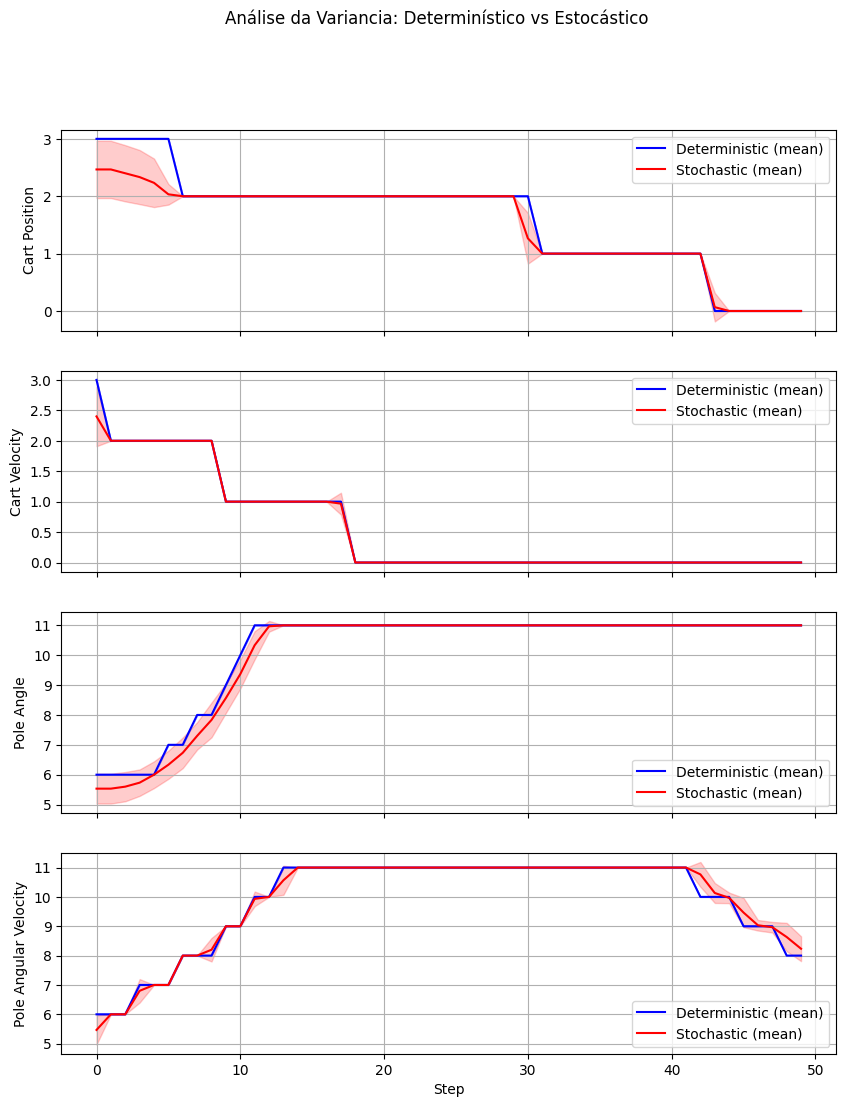

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for i, label in enumerate(STATES):
    axs[i].plot(mean_dt[:, i], label="Deterministic (mean)", color="blue")
    axs[i].fill_between(range(N_STEPS), mean_dt[:, i]-std_dt[:, i], mean_dt[:, i]+std_dt[:, i],
                        color="blue", alpha=0.2)
    
    axs[i].plot(mean_stc[:, i], label="Stochastic (mean)", color="red")
    axs[i].fill_between(range(N_STEPS), mean_stc[:, i]-std_stc[:, i], mean_stc[:, i]+std_stc[:, i],
                        color="red", alpha=0.2)
    
    axs[i].set_ylabel(label)
    axs[i].legend()
    axs[i].grid(True)

axs[3].set_xlabel("Step")
plt.suptitle("Análise da Variancia: Determinístico vs Estocástico")
plt.show()

# Agentes

## Monte Carlo

In [28]:
# --- Configurações MONTE CARLO ---
N0 = 100
GAMMA = 0.99
N_EPISODES = 500
MAX_STEPS = 200

In [29]:
agent_dt = MonteCarloAgent(N_ACTIONS, n0=N0, gamma=GAMMA)
agent_stc = MonteCarloAgent(N_ACTIONS, n0=N0, gamma=GAMMA)

In [30]:
rewards_dt = []
rewards_stc = []

for ep in range(N_EPISODES):
    # ---- Determinístico ----
    state, _ = env_dt.reset()
    episode = []
    total_reward = 0
    for _ in range(MAX_STEPS):
        action = agent_dt.select_action(state)
        next_state, r, done, truncated, _ = env_dt.step(action)
        episode.append((state, action, r))
        state = next_state
        total_reward += r
        if done or truncated:
            break
    agent_dt.update(episode)
    rewards_dt.append(total_reward)

    # ---- Estocástico ----
    state, _ = env_stc.reset()
    episode = []
    total_reward = 0
    for _ in range(MAX_STEPS):
        action = agent_stc.select_action(state)
        next_state, r, done, truncated, _ = env_stc.step(action)
        episode.append((state, action, r))
        state = next_state
        total_reward += r
        if done or truncated:
            break
    agent_stc.update(episode)
    rewards_stc.append(total_reward)

## Q-Learning

In [24]:
# Parâmetros Q Learning
N_EPISODES = 1000
GAMMA = 0.99
N0 = 100

In [25]:
agent = QLearningAgent(N_STATES, N_ACTIONS, gamma=GAMMA, n0=N0)

In [26]:
rewards_per_episode = []
for ep in range(N_EPISODES):
    state, _ = env_dt.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env_dt.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)

## SARSA

In [22]:
N_EPISODES = 5000
GAMMA = 0.99
N0 = 100
bins = (6, 6, 12, 12)  # discretização do estado
lambdas = [0.0, 0.2, 0.5, 0.7, 0.9, 1.0]

In [31]:
results_dt = {}
results_stc = {}

n_actions = env_dt.action_space.n

for lam in lambdas:
    print(f"\nTraining SARSA(λ={lam}) deterministic...")
    agent_dt = SarsaLambdaAgent(n_actions, gamma=GAMMA, N0=N0, lam=lam)
    rewards_per_episode = []

    for ep in range(N_EPISODES):
        state, _ = env_dt.reset()
        action = agent.select_action(state)
        episode = []
        done = False

        while not done:
            next_state, reward, done, truncated, info = env_dt.step(action)
            next_action = agent.select_action(next_state)

            episode.append((state, action, reward))

            state = next_state
            action = next_action

            if done or truncated:
                break

        # Atualiza Q(s,a)
        agent.update(episode)

        total_reward = sum([x[2] for x in episode])
        rewards_per_episode.append(total_reward)

        if (ep + 1) % 500 == 0:
            print(f"Episode {ep + 1}/{N_EPISODES} | Total reward: {total_reward}")
    results_dt[lam] = rewards_per_episode

    print(f"\nTraining SARSA(λ={lam}) stochastic...")
    agent_stc = SarsaLambdaAgent(n_actions, gamma=GAMMA, N0=N0, lam=lam)
    rewards_per_episode = []

    for ep in range(N_EPISODES):
        state, _ = env_stc.reset()
        action = agent.select_action(state)
        episode = []
        done = False

        while not done:
            next_state, reward, done, truncated, info = env_stc.step(action)
            next_action = agent.select_action(next_state)

            episode.append((state, action, reward))

            state = next_state
            action = next_action

            if done or truncated:
                break

        # Atualiza Q(s,a)
        agent.update(episode)

        total_reward = sum([x[2] for x in episode])
        rewards_per_episode.append(total_reward)

        if (ep + 1) % 500 == 0:
            print(f"Episode {ep + 1}/{N_EPISODES} | Total reward: {total_reward}")
    results_stc[lam] = rewards_per_episode

NameError: name 'lambdas' is not defined